In [1]:
import pandas as pd
import sys

sys.path.append("../..")
from common.utils import timestep_csv_names

In [2]:
import os
root_dir = "../../../data/one_day_data/"
assert os.path.exists(root_dir)

In [4]:
import numpy as np


def calc_u_v(df, ob_point):
    wind_dir = float(df["WD1"])
    wind_speed = float(df["WS1"])

    rads = np.radians(float(wind_dir))
    wind_u, wind_v = -1 * wind_speed * np.cos(rads), -1 * wind_speed * np.sin(rads)
    # wind_u_v = wind_components(wind_speed * units("m/s"), wind_dir * units.deg)

    return [
        ob_point,
        round(wind_u, 5),
        round(wind_v, 5),
    ]  # (index, u wind, v wind) u: X (East-West) v: Y(North-South)

_timestep_csv_names = timestep_csv_names(delta=10)

target_cols = ["U-Wind", "V-Wind"]
dates, u_wind_values, v_wind_values = [], [], []
for year in os.listdir(root_dir):
    for month in os.listdir(root_dir + f"/{year}"):
        for date in os.listdir(root_dir + f"/{year}/{month}"):
            _u_wind_values, _v_wind_values = [], []
            minimum_data_length = 40
            start_time = "0-0"
            for csv_filename in _timestep_csv_names:
                csv_path = os.path.join(
                        root_dir,
                        year, month, date, csv_filename
                    )
                parquet_path = csv_path.replace(".csv", ".parquet.gzip")
                parquet_df = pd.read_parquet(parquet_path, engine="pyarrow")
                wind_df = pd.DataFrame([calc_u_v(parquet_df.loc[i, :], i) for i in parquet_df.index], columns=["OB-Point", "U-Wind", "V-Wind"])
                parquet_df["V-Wind"], parquet_df["U-Wind"] = wind_df["V-Wind"], wind_df["U-Wind"]

                _u_wind_values.append(wind_df["U-Wind"].max())
                _u_wind_values.append(wind_df["U-Wind"].min())

                _v_wind_values.append(wind_df["V-Wind"].max())
                _v_wind_values.append(wind_df["V-Wind"].min())

                if len(parquet_df.index) < minimum_data_length:
                    minimum_data_length = len(parquet_df.index)

            if minimum_data_length > 0:
                dates.append(date)
                dates.append(date)
                
                u_wind_values.append(max(_u_wind_values))
                u_wind_values.append(min(_u_wind_values))

                v_wind_values.append(max(_v_wind_values))
                v_wind_values.append(min(_v_wind_values))

df = pd.DataFrame({"date": dates, "U-Wind": u_wind_values, "V-Wind": v_wind_values})
df = df.sort_values(by="date")
df.reset_index()
df.head()

,date,U-Wind,V-Wind
712,2019-10-01,3.44270,3.77154
713,2019-10-01,-3.09245,-2.02254
710,2019-10-02,6.06768,7.56200
711,2019-10-02,-14.40000,-9.30000
721,2019-10-03,-4.34583,-3.69775


In [5]:
df["month"] = df["date"].apply(lambda x: x.split("-")[0] + "-" + x.split("-")[1])
df.head()

,date,U-Wind,V-Wind,month
712,2019-10-01,3.44270,3.77154,2019-10
713,2019-10-01,-3.09245,-2.02254,2019-10
710,2019-10-02,6.06768,7.56200,2019-10
711,2019-10-02,-14.40000,-9.30000,2019-10
721,2019-10-03,-4.34583,-3.69775,2019-10


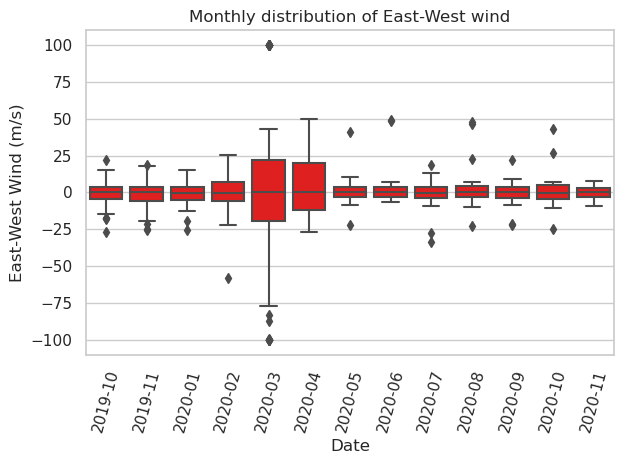

In [10]:
# U-wind

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df, x="month", y="U-Wind", color="red")
plt.xticks(rotation=75)
ax.set_title("Monthly distribution of East-West wind")
ax.set_ylabel("East-West Wind (m/s)")
ax.set_xlabel("Date")

plt.tight_layout()
plt.savefig("./u_wind.png")
plt.show()
plt.close()

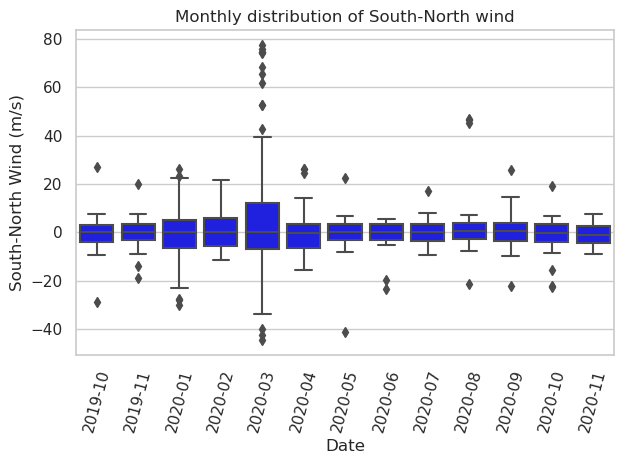

In [11]:
# V-wind

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df, x="month", y="V-Wind", color="blue")
plt.xticks(rotation=75)
ax.set_title("Monthly distribution of South-North wind")
ax.set_ylabel("South-North Wind (m/s)")
ax.set_xlabel("Date")

plt.tight_layout()
plt.savefig("./v_wind.png")
plt.show()
plt.close()